# Предсказание цен на телефоны

- `ID` - уникальный ключ
- `battery_power` - Total energy a battery can store in - one time measured in mAh
- `blue` - has bluetooth or not
- `clock_speed` - speed at which microprocessor executes instructions
- `dual_sim` - has dual sim support or not
- `fc` - front camera mega pixels
- `four_g` - has 4G or not
- `int_memory` - internal memory in gigabytes
- `m_dep` - mobile depth in cm
- `mobile_wt` - weight of mobile phone
- `n_cores` - number of cores of processor
- `pc` - primary camera mega pixels
- `px_height` - Pixel Resolution Height
- `px_width` - Pixel Resolution Width
- `ram` - Random Access Memory in Megabytes
- `sc_h` - Screen Height of mobile in cm
- `sc_w` -  Screen Width of mobile in cm
- `talk_time` - longest time that a single battery charge will last when you are constantly talking on the phone
- `three_g` - has 3G or not
- `touch_screen` - Has touch screen or not
- `wifi` - has wifi or not
- `price_range` - this is the target variable with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).


## Загрузка данных и EDA

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, \
ShuffleSplit, learning_curve, LearningCurveDisplay, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve

from yellowbrick.model_selection import FeatureImportances

from lightgbm import LGBMClassifier, cv

In [2]:
# фиксируем random_state
random = 23

In [3]:
# загрузка данных
sharing_url = "https://drive.google.com/file/d/1XkKOS6jbke3JYWTj8V_xS46txe820rZ_/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df_mobile = pd.read_csv(download_url)

In [4]:
# EDA: смотрим на типы переменных
df_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Типы переменных соответствуют тому, что бы мы ожидали там увидеть (везде integer, в т. ч. для бинарных переменных, кроме двух переменных с дробными значениями, там float).

In [5]:
# наличие null/NA
print(df_mobile.isnull().values.any())
print(df_mobile.isna().values.any())

False
False


В данных отсутствует столбец с ID. Давайте на всякий случай его добавим.

In [6]:
df_mobile['id'] = [i for i in range(len(df_mobile))]

Проверим распределение таргета.

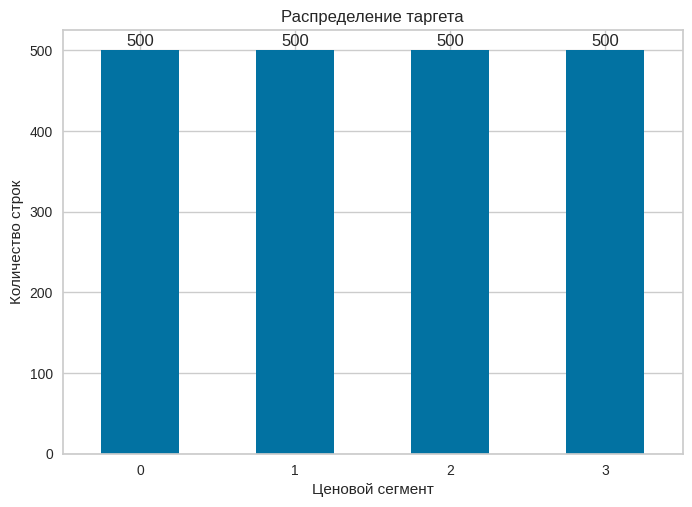

In [7]:
target = df_mobile.price_range

target.value_counts().sort_index().plot.bar()
plt.xlabel('Ценовой сегмент')
plt.ylabel('Количество строк')
plt.title('Распределение таргета')

for index, value in enumerate(target.value_counts().sort_index()):
    plt.text(index, value+5, str(value), ha='center')

plt.xticks(rotation=0)
plt.show()

Данные сбалансированы: для каждого ценового сегмента существует одинаковое количество строк.

Из интереса построим корреляционную матрицу между различными фичами. Возможно, между какими-то признаками корреляция будет достаточно сильная, чтобы задуматься об их агрегации.

Я использую коэффициент корреляции Пирсона, который заложен в df.corr() по умолчанию, поскольку он более мощный в сравнении с коэффициентами Кендалла и Спирмена. Я понимаю, что перед этим нужно было сделать для всех распределений тест на нормальность (ну и бинарные переменные так вообще не очень корректно сопоставлять), однако я решила на данном этапе пренебречь этим, поскольку тут все же разведочный анализ данных, а не полноценный.

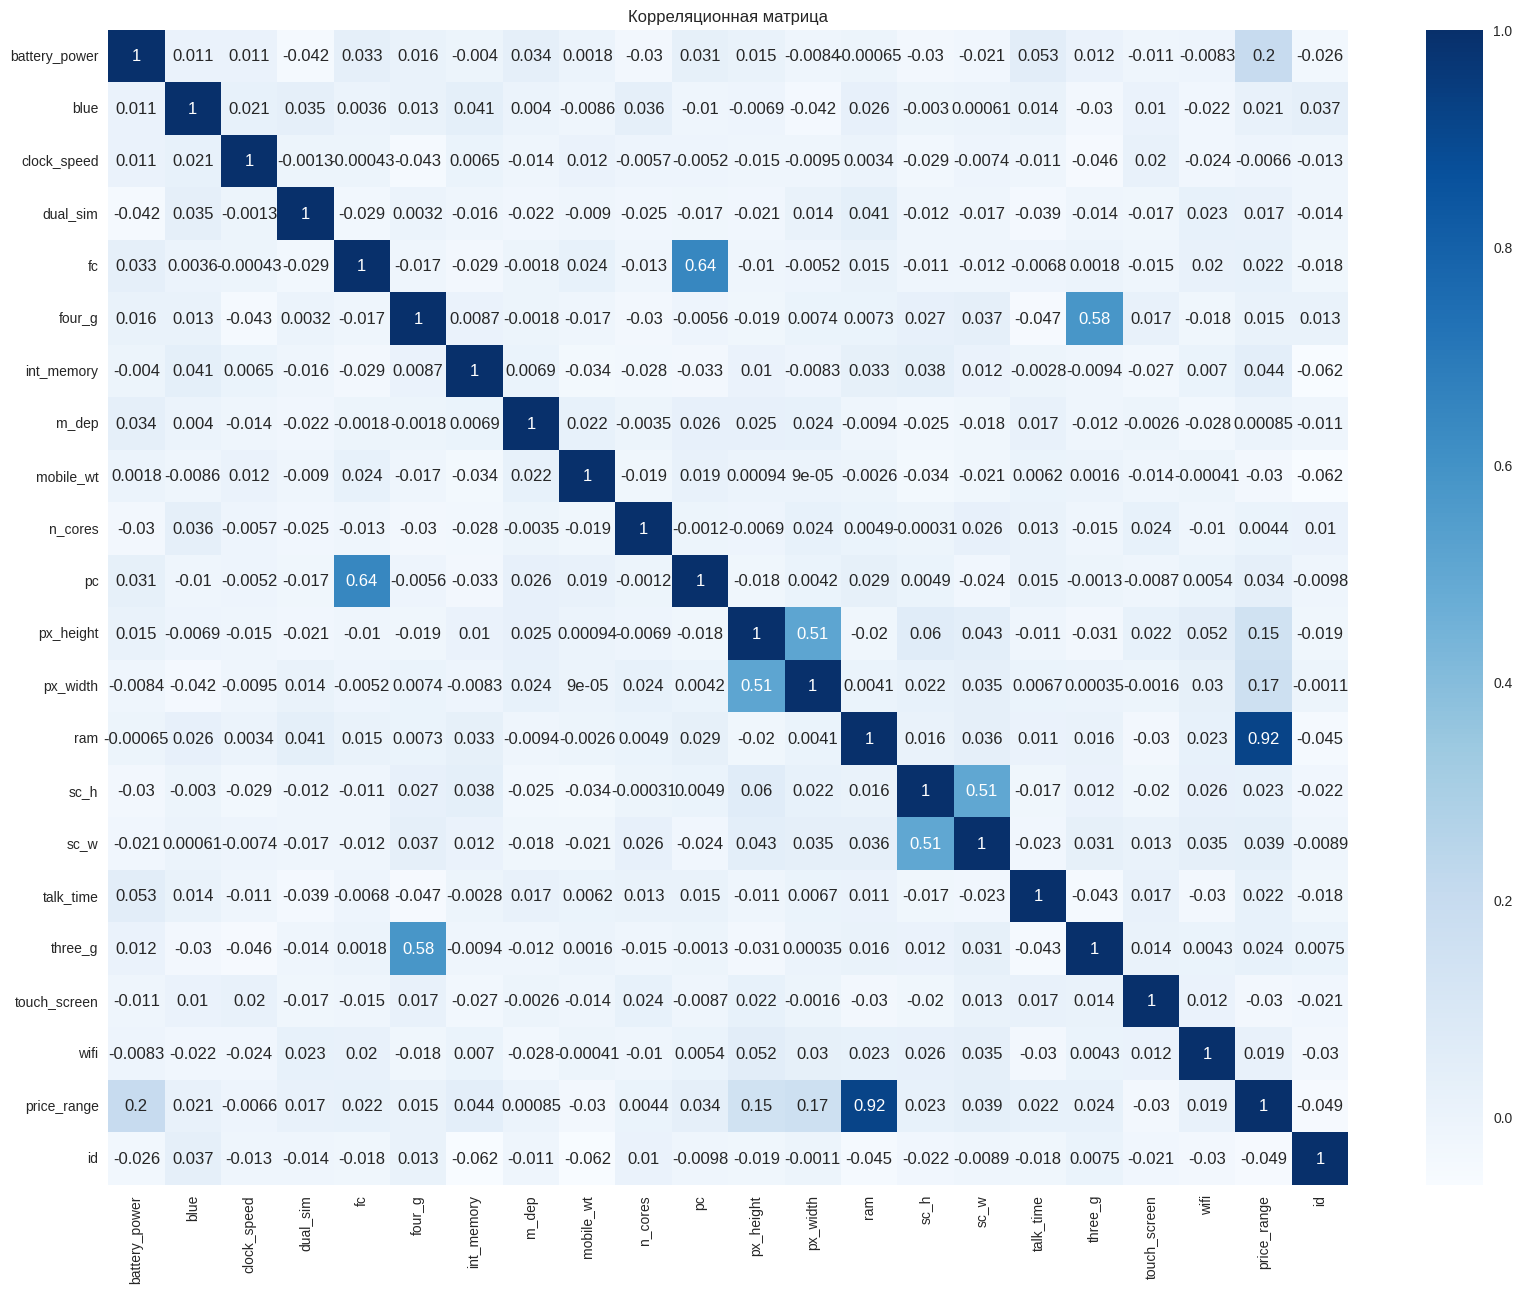

In [8]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_mobile.corr(), annot=True, cmap='Blues')
plt.title('Корреляционная матрица')
plt.show()

Выделилось насколько пар:
1. `three-g` - `four-g`: коэффициент корреляции - 0.58, умеренная связь;
3. `sc-w` - `sc-h`: коэффициент корреляции - 0.51, умеренная связь;
2. `px-width` - `px-height`: коэффициент корреляции - 0.51, умеренная связь;
4. `pc` - `fc`: коэффициент корреляции - 0.64, умеренная связь;
5. `price-range` - `ram`: коэффициент корреляции - 0.92, очень сильная связь.

Корреляция фичей в целом объяснима за счет common sense: понятно, что если у телефона есть 4G, то будет и 3G; чем больше длина, тем больше ширина (для `sc-w` - `sc-h` и `px-width` - `px-height`); если у телефона хорошая основная камера, то фронтальная тоже будет на хорошая.

Несколько важных поинтов:
- среди фичей нет сильно коррелирующих между собой, поэтому я не буду ничего агрегировать и лучше построю более сложную модель, чтобы точно ничего не потерять;
- скорее всего, `ram` будет одной из самых важных фичей (проверим, когда будем анализировать важность признаков для логистической регрессии);
- если между какими-то переменными существует нелинейная связь, то тут мы ее не поймали.

По последнему пункту: поймать нелинейные зависимости нам может помочь PolynomialFeatures. Обучим две модели: с feautre-engineering через PolynomialFeatures и без него.

## Метрики качества

Таргет price_range является ранговой переменной, соответственно, для ее предсказания разумно обучать классификатор. Для оценки качества классификатора будут использованы следующие метрики:
- `accuracy`: покажет долю верно предсказанных значений;
- `macro average precision`: среднее точности по всем классам;
- `macro average recall`: среднее полноты по всем классам;
- `macro average f1-score`: среднее f-меры по всем классам;
- `macro average ROC-AUC`: среднее ROC-AUC по всем классам.

Разумно использовать именно эти метрики (а не weighted-альтернативу), поскольку распределение по таргету у нас сбалансировано.

Для оценки самого классификатора будут использованы следующие метрики:
- `Log loss`: покажет, насколько модель выдает высокие вероятности для своих предсказаний (степень ее уверенности в результате), оценивать будем по всем моделям сразу в самом конце

In [9]:
def get_classification_metrics(model, X_test, y_test):

    # general metrics
    y_preds = model.predict(X_test)
    print(classification_report(y_preds, y_test))

    # roc-auc
    y_proba = model.predict_proba(X_test)
    macro_auc = roc_auc_score(y_test,
                              y_proba,
                              multi_class='ovr',
                              average='macro')
    print('ROC-AUC is ', macro_auc)

In [10]:
def get_feature_importance(model, X_train, y_train):
    viz = FeatureImportances(model, relative=False,
                             colormap='cool')
    viz.fit(X_train, y_train)
    viz.show()

## Логистическая регрессия: baseline

In [11]:
# подготовим наши выборки

col_to_drop = ['id', 'price_range']
X = df_mobile.drop(col_to_drop, axis=1).copy()
y = df_mobile.price_range.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=random)

In [12]:
# нормализуем фичи в выборках

scaler = MinMaxScaler()

pandas_columns = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=pandas_columns)
X_test = pd.DataFrame(X_test, columns=pandas_columns)

In [13]:
# логистическая регрессия: базовая модель

logreg_baseline = LogisticRegression()
logreg_baseline.fit(X_train, y_train)

LogisticRegression()

In [14]:
get_classification_metrics(logreg_baseline, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        47
           1       0.85      0.85      0.85        39
           2       0.86      0.91      0.89        56
           3       0.98      0.95      0.96        58

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

ROC-AUC is  0.9928435545644666


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


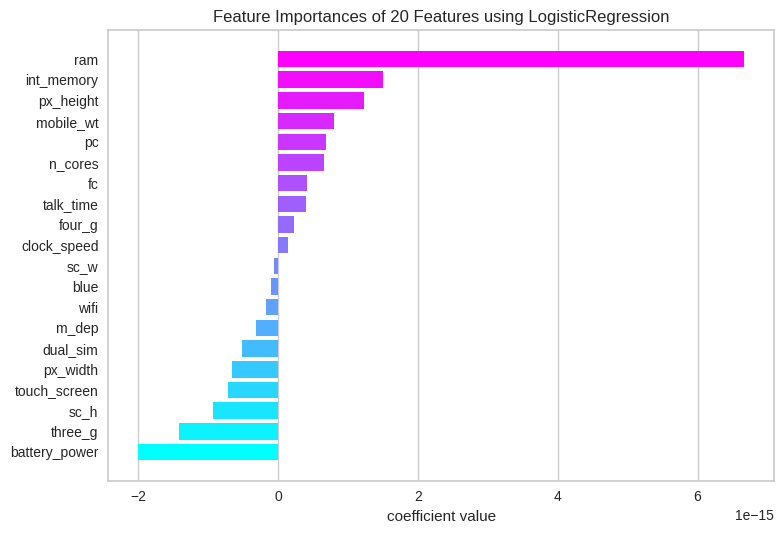

In [15]:
# важность признаков
get_feature_importance(logreg_baseline, X_train, y_train)

При EDA мы сделали верное предположение о важности параметра `ram` для предсказания.

## Логистическая регрессия с подобранными гиперпараметрами

In [16]:
tuned_param = {'penalty': ['l1', 'l2', 'elasticnet', None],
               'C': [1, 10, 100, 1000],
               'solver': ['lbfgs', 'liblinear','newton-cg',
                          'newton-cholesky', 'sag', 'saga']}

# cv=5, поскольку это классическое деление на фолды
clf = GridSearchCV(estimator=LogisticRegression(),
                   param_grid=tuned_param,
                   cv=5)

In [17]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [18]:
# получаем наиболее эффективные параметры
clf.best_params_

{'C': 1000, 'penalty': 'l2', 'solver': 'newton-cholesky'}

In [19]:
# обучаем новую логистическую регрессию
logreg_crossval = LogisticRegression(penalty='l2',
                                     C=1000,
                                     solver='newton-cholesky')

logreg_crossval.fit(X_train, y_train)

LogisticRegression(C=1000, solver='newton-cholesky')

In [20]:
# результаты
get_classification_metrics(logreg_crossval, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.95      1.00      0.97        37
           2       1.00      0.98      0.99        60
           3       0.98      1.00      0.99        55

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200

ROC-AUC is  0.9998187395713485


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


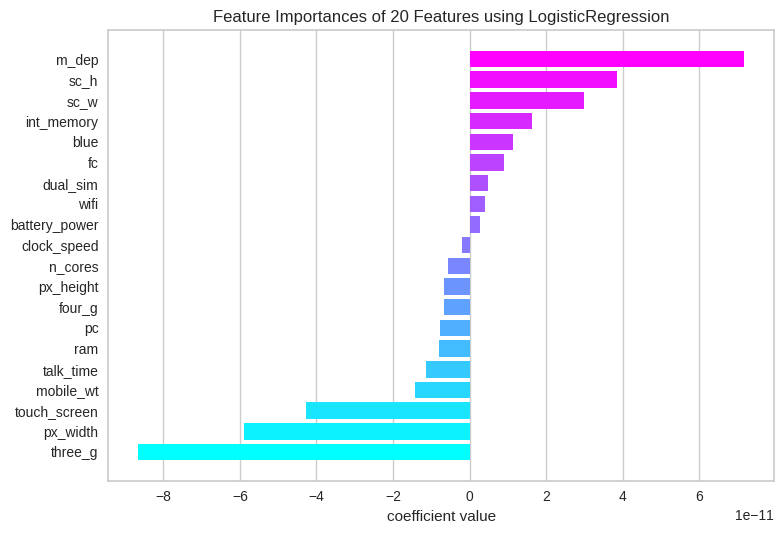

In [21]:
# важность признаков
get_feature_importance(logreg_crossval, X_train, y_train)

Интересно, что после кросс-валидации у нас улучшились метрики, при этом поменялось распределение важности признаков. Скорее всего, между таргетом и фичами `m_dep` и ниже была нелинейная связь, которую сложно было поймать через анализ корреляционной матрицы.

## LGBMClassifier: baseline

In [22]:
# инициализация модели
lgbm_baseline = LGBMClassifier()

# обучение
lgbm_baseline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score -1.377445
[LightGBM] [Info] Start training from score -1.362144
[LightGBM] [Info] Start training from score -1.406497
[LightGBM] [Info] Start training from score -1.399717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier()

In [23]:
# результаты
get_classification_metrics(lgbm_baseline, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        47
           1       0.87      0.83      0.85        41
           2       0.85      0.89      0.87        56
           3       0.95      0.95      0.95        56

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

ROC-AUC is  0.9924236883184908


Пока так себе: baseline логистической регрессии показывал более хорошие результаты.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


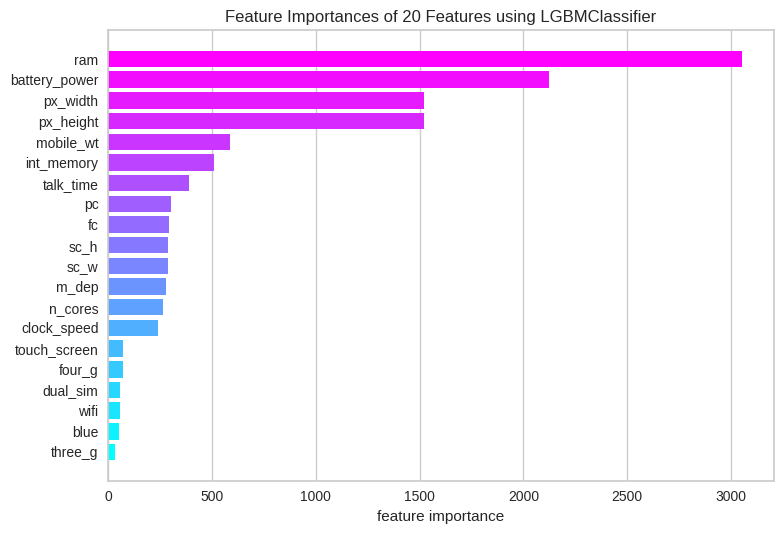

In [24]:
# важность признаков
get_feature_importance(lgbm_baseline, X_train, y_train)

Снова `ram` вышел на первое место по важности

## LGBMClassifier с подобранными гиперпараметрами

Описание гиперпараметров бустинга:

* `boosting_type`: какой алгоритм для бустинга мы будем использовать (дерево решений, DART, случайный лес); по условию подбирать гиперпараметры нам надо для деревьев решений, так что оставляем дефолтный gbdt;
* Просто параметры:
 - `num_leaves`: разветвленность наших деревьев;
 - `max_depth`: максимальная глубина деревьев;
 - `n_estimators`: количество деревьев;
 - `learning_rate`: шаг градиентного бустинга.
* Параметры на страже борьбы с переобучением:
 - `min_split_gain`: минимальное значение gain, необходимое для выполнения разделения узла;
 - `min_child_weight`: поможет нам не ветвить не значимые узлы;
 - `min_child_samples`: минимальное количество объектов в листе;
 - `colsample_bytree`: доля признаков для каждого дерева;
 - `reg_alpha`: L1, снижает веса неважных признаков;
 - `reg_lambda`: L2, сглаживает веса.

In [25]:
params = {'num_leaves': [2**(-1), 2**5, 2**10, 2**15],
          'max_depth': [-1, 5, 10, 15],
          'n_estimators': [100, 500, 1000],
          'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],

          # борьба с переобучением
          'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'min_child_weight': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5],
          'min_child_samples': [10, 20, 30, 40],
          'colsample_bytree': [0.8, 0.9, 1],
          'subsample': [0.7, 0.8, 0.9],
          'reg_alpha': [0, 0.1, 1, 10],
          'reg_lambda': [0, 0.1, 1, 5, 10]}

# я бы очень хотела сделать GridSearchCV, но с таким количеством у меня будет
# ~ 1.5млн моделей, так что делаем RandomizedSearchCV

clf = RandomizedSearchCV(estimator=LGBMClassifier(),
                         param_distributions=params,
                         n_iter=50,
                         cv=5)

clf.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning]

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py", 

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5],
                                        'max_depth': [-1, 5, 10, 15],
                                        'min_child_samples': [10, 20, 30, 40],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 2, 3, 4, 5],
                                        'min_split_gain': [0, 0.1, 0.2, 0.3,
                                                           0.4, 0.5],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [0.5, 32, 1024, 32768],
                                        'reg_alpha': [0, 0.1, 1, 10],
                                        'reg_lambda': [0, 0.1, 1, 5, 10],
                                        'subsample': [0.7, 0.8, 0.9]})

In [26]:
# всех с днем подобранных гиперпараметров
clf.best_params_

{'subsample': 0.8,
 'reg_lambda': 10,
 'reg_alpha': 0.1,
 'num_leaves': 32,
 'n_estimators': 100,
 'min_split_gain': 0.3,
 'min_child_weight': 0.1,
 'min_child_samples': 20,
 'max_depth': -1,
 'learning_rate': 0.4,
 'colsample_bytree': 0.9}

In [27]:
# после некоторого количества страданий до меня дошло,
# что в принципе необязательно прописывать все параметры вручную
lgbm_crossval = LGBMClassifier(**clf.best_params_)

lgbm_crossval.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score -1.377445
[LightGBM] [Info] Start training from score -1.362144
[LightGBM] [Info] Start training from score -1.406497
[LightGBM] [Info] Start training from score -1.399717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.4, min_child_weight=0.1,
               min_split_gain=0.3, num_leaves=32, reg_alpha=0.1, reg_lambda=10,
               subsample=0.8)

In [28]:
get_classification_metrics(lgbm_crossval, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.85      0.82      0.84        40
           2       0.83      0.89      0.86        55
           3       0.96      0.95      0.96        57

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

ROC-AUC is  0.991420729857332


Стало не сильно лучше. Давайте сократим количество гиперпараметров, оставив самые важные, и переберем их через GridSearch

In [29]:
params = {'max_depth': [-1, 5, 10, 15],
          'n_estimators': [100, 500, 1000],
          'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}


clf = GridSearchCV(estimator=LGBMClassifier(),
                   param_grid=params,
                   cv=5)

clf.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [-1, 5, 10, 15],
                         'n_estimators': [100, 500, 1000]})

In [30]:
# всех с днем подобранных гиперпараметров
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}

In [31]:
lgbm_crossval_2 = LGBMClassifier(**clf.best_params_)

lgbm_crossval_2.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score -1.377445
[LightGBM] [Info] Start training from score -1.362144
[LightGBM] [Info] Start training from score -1.406497
[LightGBM] [Info] Start training from score -1.399717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(max_depth=5, n_estimators=1000)

In [32]:
get_classification_metrics(lgbm_crossval_2, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.87      0.87      0.87        39
           2       0.86      0.89      0.88        57
           3       0.95      0.95      0.95        56

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

ROC-AUC is  0.9916547945167768


Ура, метрики немного выросли

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


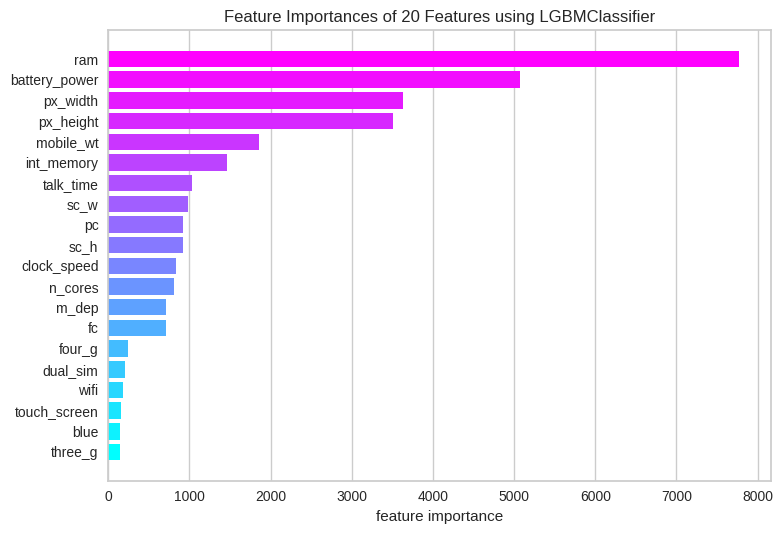

In [33]:
get_feature_importance(lgbm_crossval_2, X_train, y_train)

Сравним кросс-валидированный бустинг с кросс-валидированным логрегом.

**Бустинг**

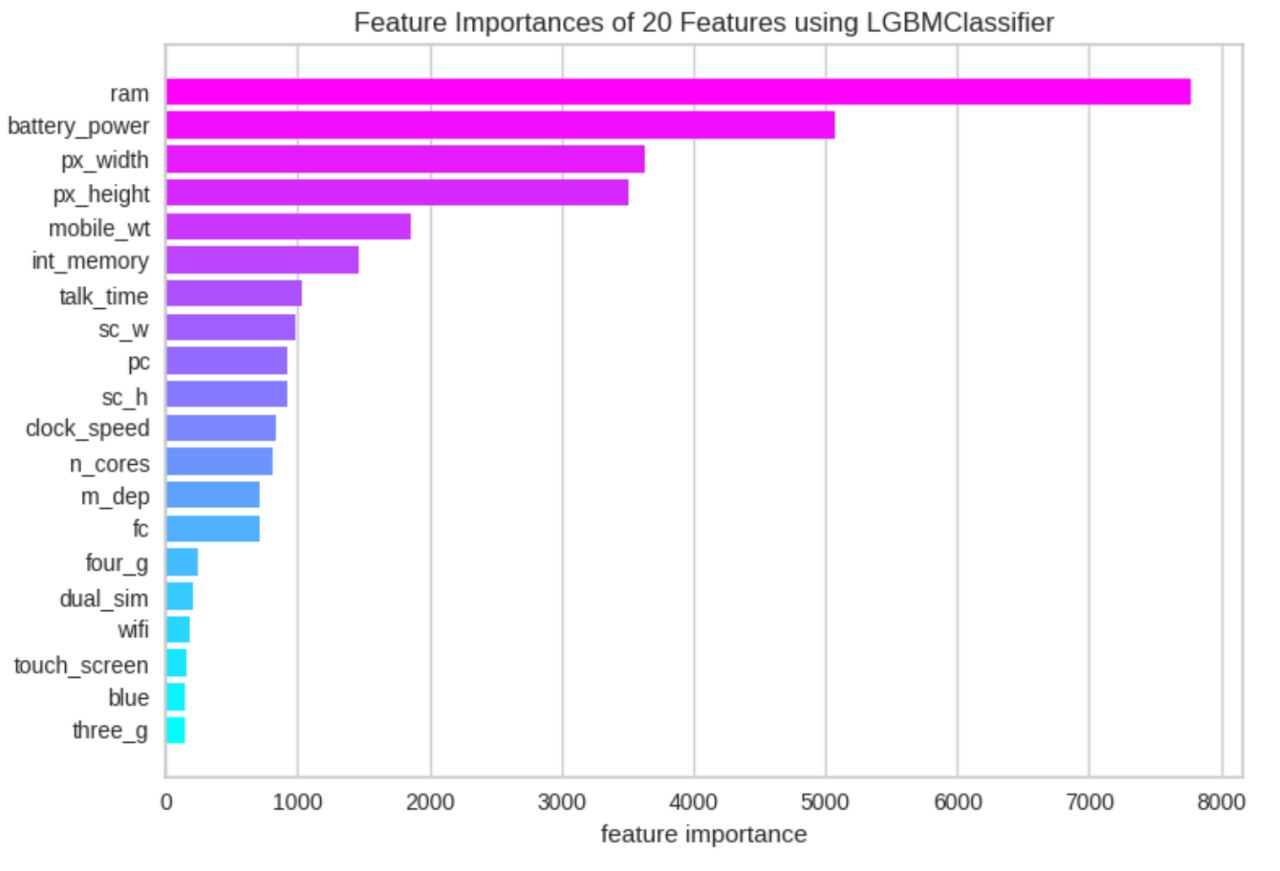

** Логистическая регрессия **

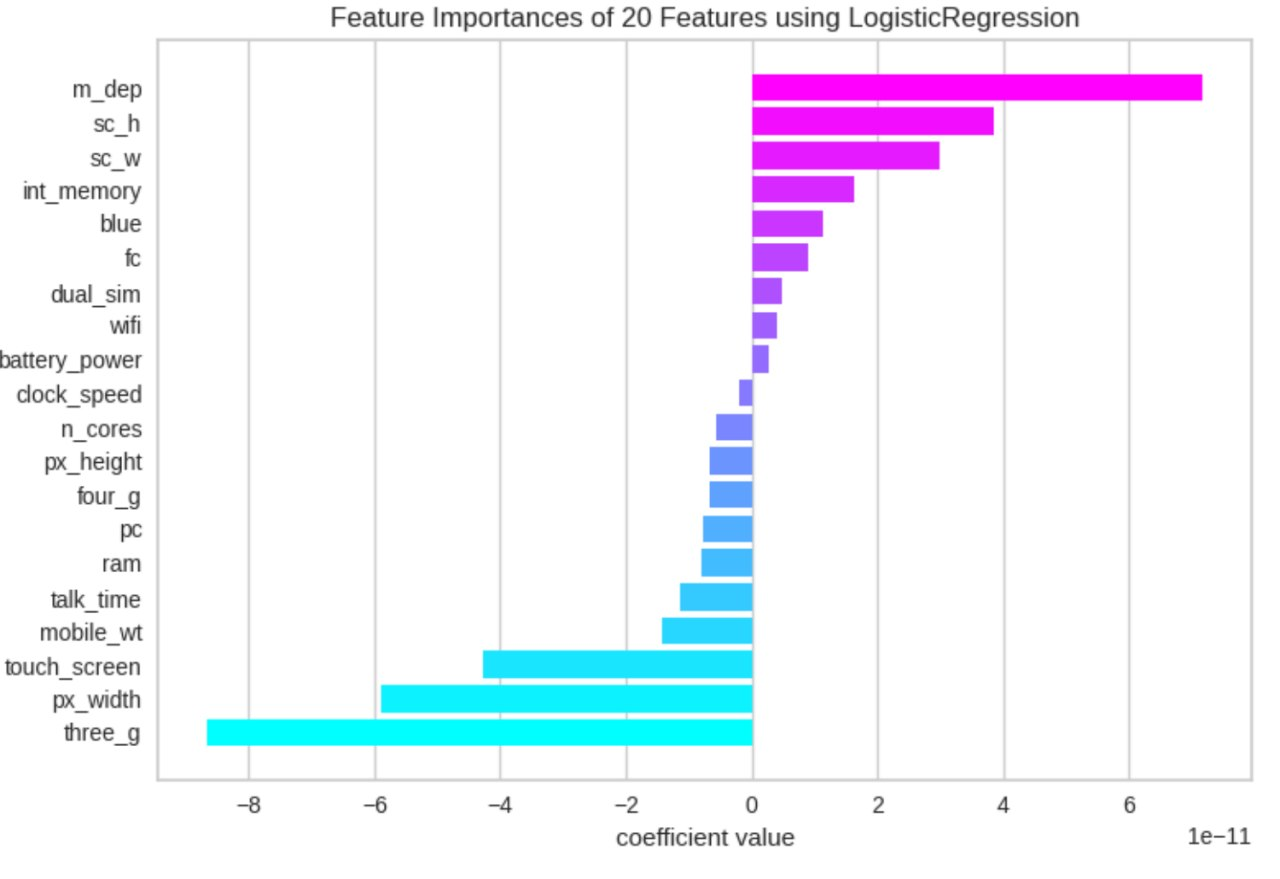

В принципе, распределение по признакам в целом достаточно разное. У этого может быть несколько причин:
* линейная модель не может выявить взаимодействия признаков
* бустинг, напротив, автоматически учитывает взаимодействия признаков

## Хорошие и плохие предсказания на основе бустинга (кросс-валидированная модель-2)

In [34]:
boosting_preds = lgbm_crossval_2.predict(X_test)

for i in range(len(boosting_preds)):
    if boosting_preds[i] == y_test.iloc[i]:
        print('Пример хорошего предсказания: ', y_test.iloc[i])
        print('Фичи: ', X_test.iloc[i])
        print('____')
    else:
        print(f"Пример плохого предсказания: реальное значение: {y_test.iloc[i]}; \
        предсказанное бустингом: {boosting_preds[i]}")
        print('Фичи: ', X_test.iloc[i])

Пример хорошего предсказания:  0
Фичи:  battery_power    0.338009
blue             1.000000
clock_speed      0.960000
dual_sim         1.000000
fc               0.263158
four_g           1.000000
int_memory       0.306452
m_dep            0.777778
mobile_wt        0.875000
n_cores          1.000000
pc               0.600000
px_height        0.244388
px_width         0.220961
ram              0.279262
sc_h             0.214286
sc_w             0.333333
talk_time        0.555556
three_g          1.000000
touch_screen     1.000000
wifi             0.000000
Name: 0, dtype: float64
____
Пример хорошего предсказания:  2
Фичи:  battery_power    0.083500
blue             0.000000
clock_speed      0.080000
dual_sim         1.000000
fc               0.105263
four_g           1.000000
int_memory       0.338710
m_dep            0.444444
mobile_wt        0.891667
n_cores          0.142857
pc               0.450000
px_height        0.045918
px_width         0.556742
ram              0.855692
sc_h   

## Сравнение LogLoss всех моделей

In [35]:
def get_logloss_graph(model, y_test, X_test):
    y_pred_proba = model.predict_proba(X_test)

    n_classes = y_pred_proba.shape[1]
    plt.figure(figsize=(10, 6))

    for class_idx in range(n_classes):
        prob_true, prob_pred = calibration_curve(
            (y_test == class_idx).astype(int),
            y_pred_proba[:, class_idx],
            n_bins=10)
        plt.plot(prob_pred, prob_true, label=f"Класс {class_idx + 1}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.legend()
    plt.show()

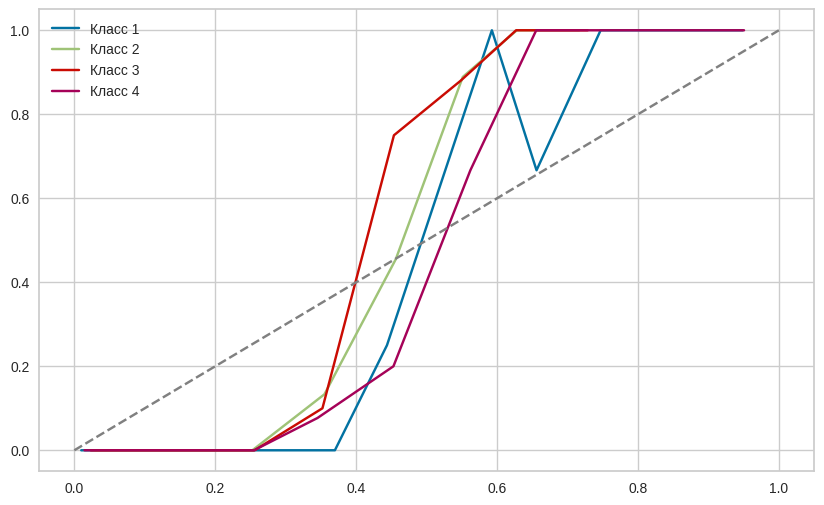

In [36]:
get_logloss_graph(logreg_baseline, y_test, X_test)

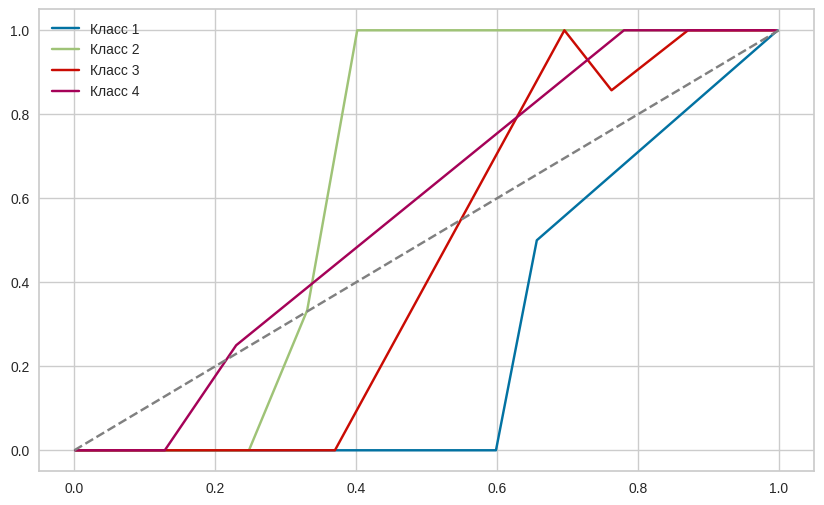

In [37]:
get_logloss_graph(logreg_crossval, y_test, X_test)

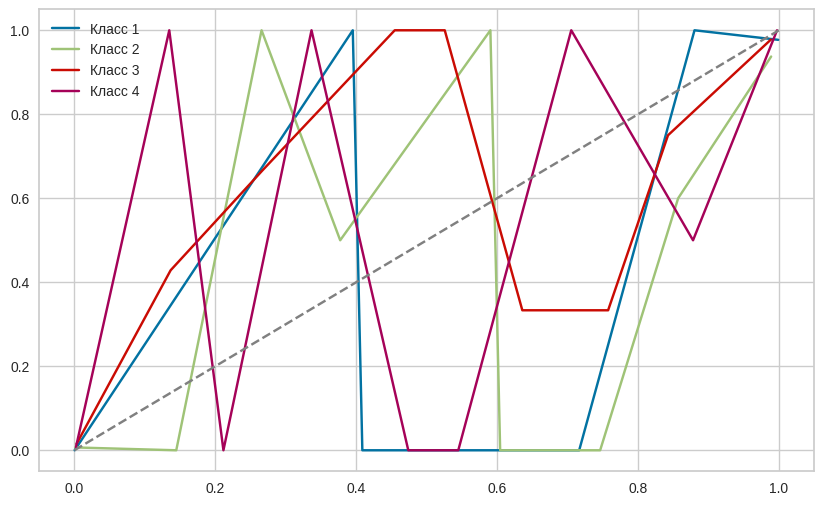

In [38]:
get_logloss_graph(lgbm_baseline, y_test, X_test)

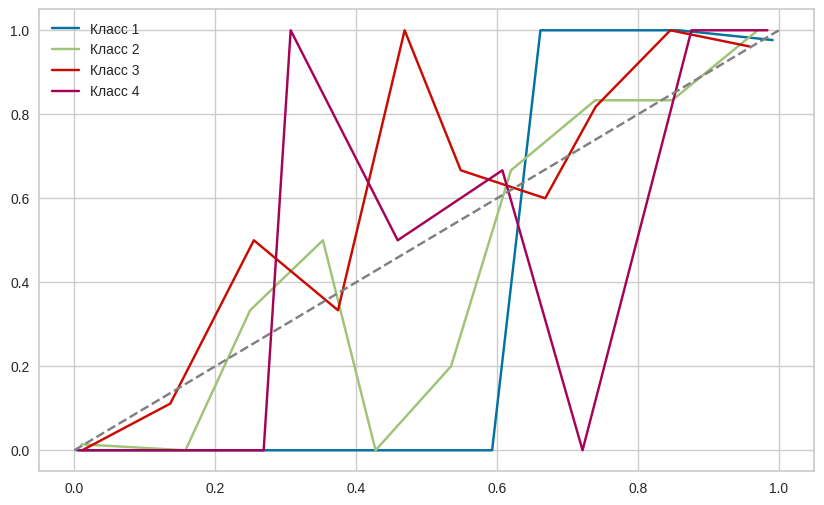

In [39]:
get_logloss_graph(lgbm_crossval, y_test, X_test)

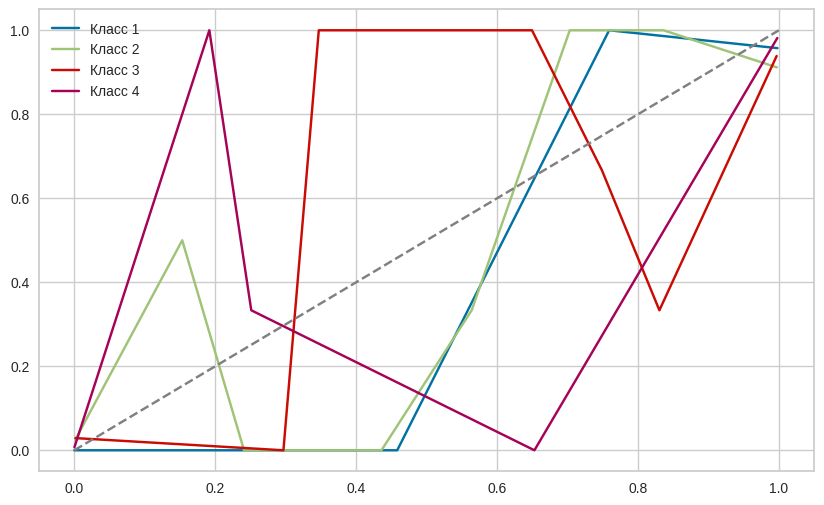

In [40]:
get_logloss_graph(lgbm_crossval_2, y_test, X_test)

Страшно это все выглядит. Я бы сказала, что логистическая регрессия с кросс-валидацией лучше всего предсказывает классы, но без кросс-валидации лучше всего откалибрована.

# Предсказание наличия возгорания

* `index` - id записи
* `UTC` - время создания записи
* `Temperature[C]` - Air Temperature
* `Humidity[%]` - Air Humidity
* `TVOC[ppb]` - Total Volatile Organic Compounds; measured in parts per billion
* `eCO2[ppm]` - co2 equivalent concentration; calculated from different values like TVCO
* `Raw H2` - raw molecular hydrogen; not compensated (Bias, temperature, etc.)
* `Raw Ethanol` -  raw ethanol gas
* `Pressure[hPa]` - Air Pressure
* `PM1.0` - particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
PM2.5 - particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
* `NC0.5` - Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);
* `NC1.0` - Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);
* `NC2.5` - Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);
* `CNT` - номер записи
* `Fire` - Alarmground truth is "1" if a fire is there

## Загрузка данных и EDA

In [41]:
# загрузка данных
sharing_url = "https://drive.google.com/file/d/1TJI9IVaZQtaTJUezLrC3WaQ-eEC40AGG/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df_firealarm = pd.read_csv(download_url)

In [42]:
# EDA: смотрим на типы переменных
df_firealarm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


Типы переменных соответствуют тому, что бы мы ожидали там увидеть (везде integer, в т. ч. для бинарных переменных, кроме восьми переменных с дробными значениями, там float).

In [43]:
print(df_firealarm.isnull().values.any())
print(df_firealarm.isna().values.any())

False
False


In [44]:
# переименуем первую колонку
df_firealarm = df_firealarm.rename(columns={'Unnamed: 0': 'index'})

Проверим распределение таргета.

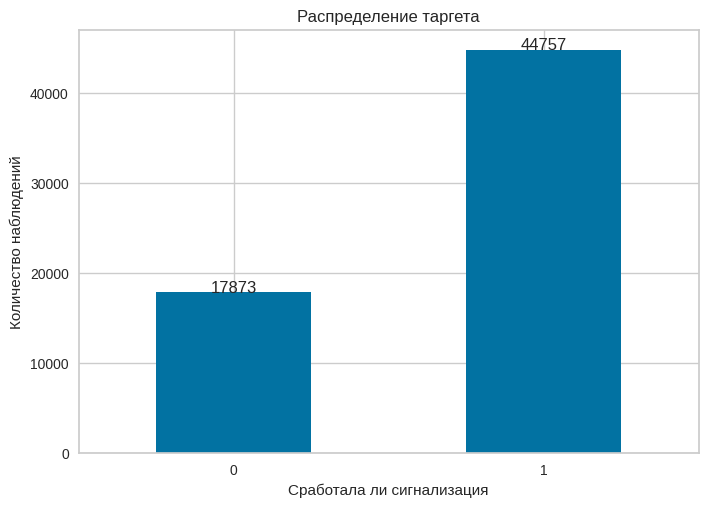

In [45]:
target = df_firealarm['Fire Alarm']

target.value_counts().sort_index().plot.bar()
plt.xlabel('Сработала ли сигнализация')
plt.ylabel('Количество наблюдений')
plt.title('Распределение таргета')

for index, value in enumerate(target.value_counts().sort_index()):
    plt.text(index, value+5, str(value), ha='center')

plt.xticks(rotation=0)
plt.show()

Данные не очень сбалансированы. Благо у нас их много, давайте выберем все наблюдения без срабатывания сигнализации и рандомно выберем 17873 наблюдения со срабатыванием.

In [46]:
alarm_triggered = df_firealarm.loc[df_firealarm['Fire Alarm'] == 1]
alarm_not_triggered = df_firealarm.loc[df_firealarm['Fire Alarm'] == 0]
chosen_rows = np.random.choice(alarm_triggered.index.values, len(alarm_not_triggered))
alarm_triggered_balanced = alarm_triggered.loc[chosen_rows]

# соединяем
df_firealarm_mod = pd.concat([alarm_triggered_balanced, alarm_not_triggered])

Снова проверим распределение таргета.

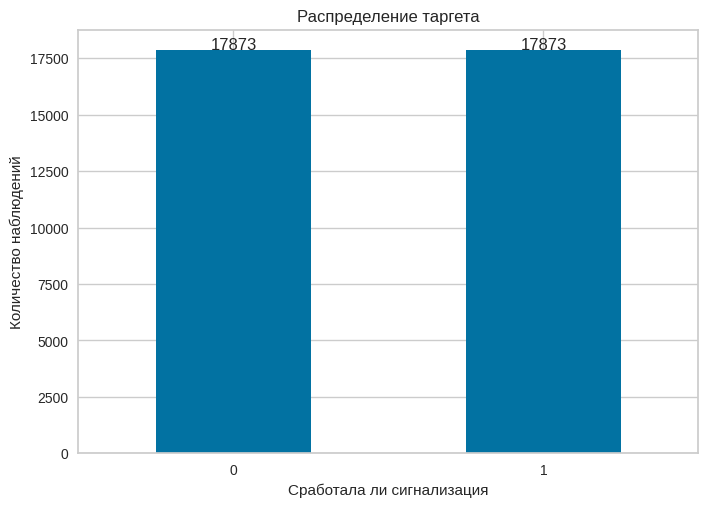

In [47]:
target = df_firealarm_mod['Fire Alarm']

target.value_counts().sort_index().plot.bar()
plt.xlabel('Сработала ли сигнализация')
plt.ylabel('Количество наблюдений')
plt.title('Распределение таргета')

for index, value in enumerate(target.value_counts().sort_index()):
    plt.text(index, value+5, str(value), ha='center')

plt.xticks(rotation=0)
plt.show()

Ура, данные сбалансированы!

Из интереса построим корреляционную матрицу между различными фичами. Возможно, между какими-то признаками корреляция будет достаточно сильная, чтобы задуматься об их агрегации.

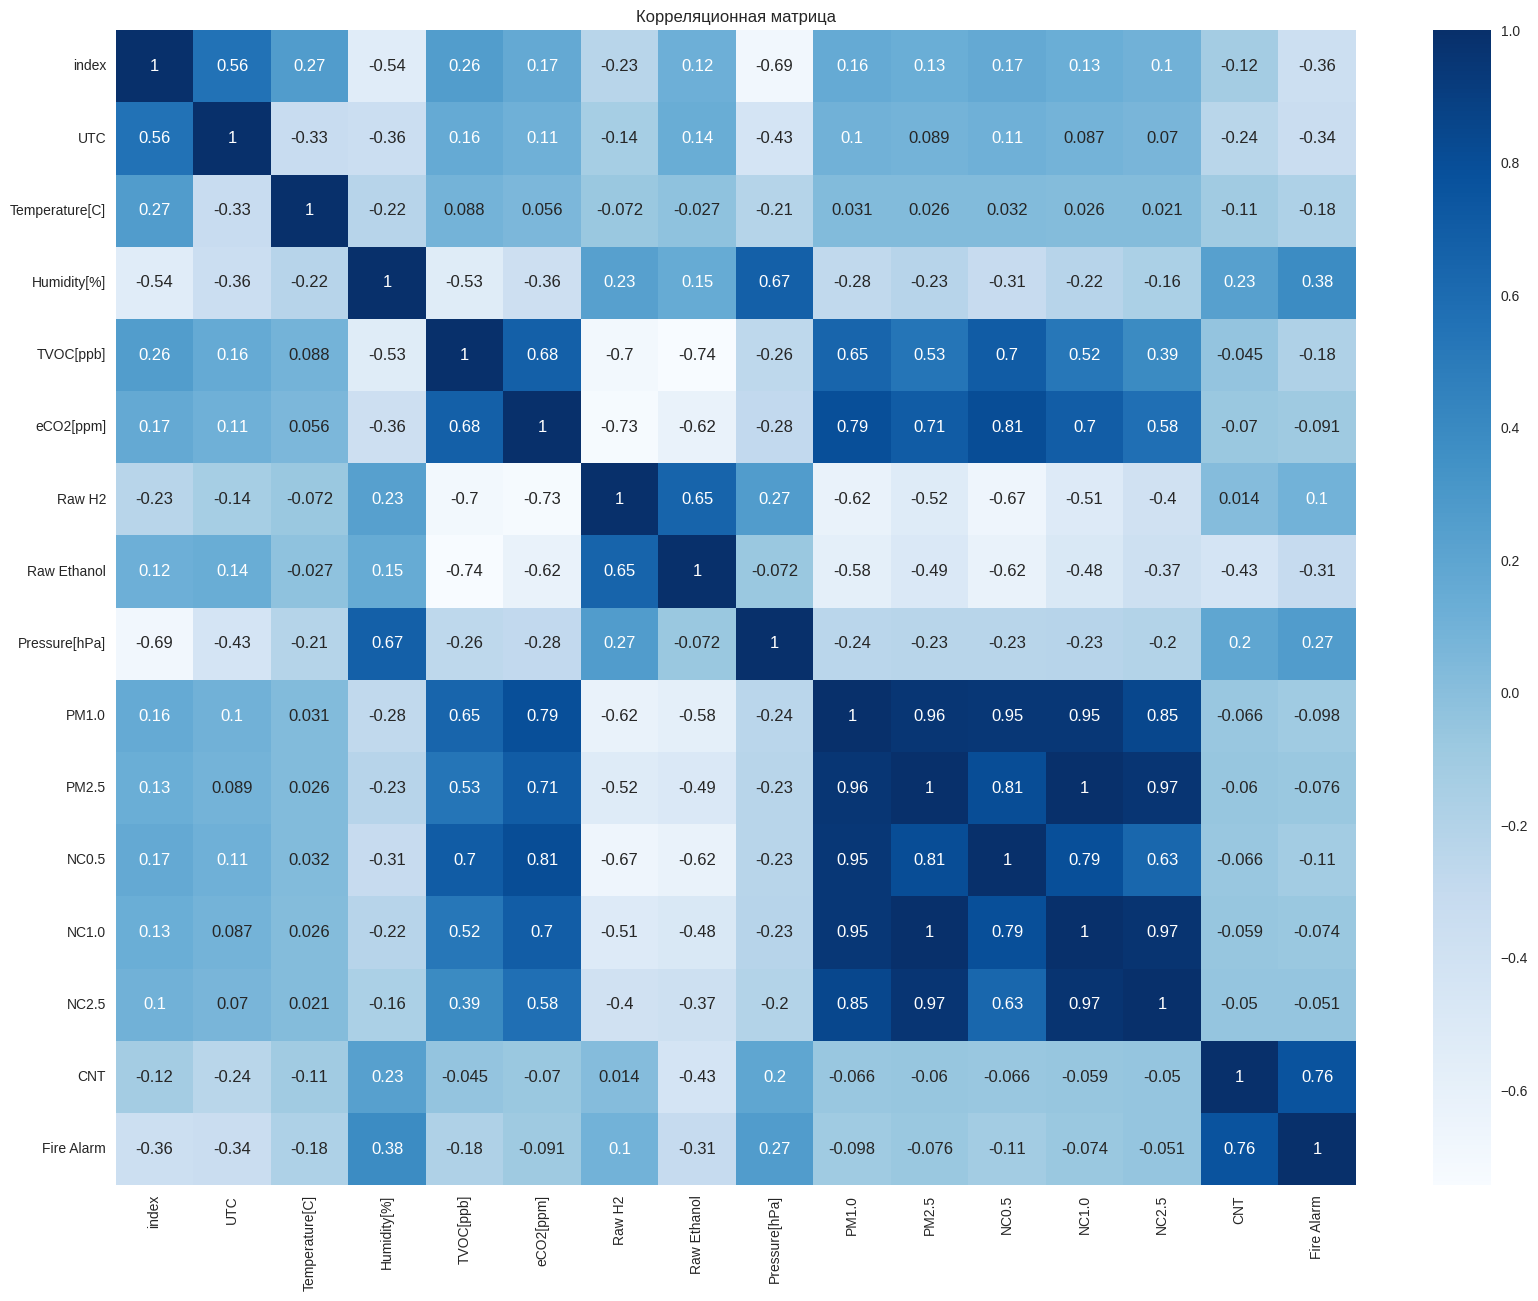

In [48]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_firealarm_mod.corr(), annot=True, cmap='Blues')
plt.title('Корреляционная матрица')
plt.show()

Тут у нас достаточно много сильно скоррелированных пар фичей. Кажется, есть смысл аггрегировать те, где корреляция хотя бы 0.8, а именно:
* `PM1.0` и `PM2.5` -> PM
* `NC0.5`, `NC1.0`, `NC2.5` -> NC

In [49]:
# на всякий пожарный (за каламбур извините)
orig_saved = df_firealarm_mod.copy()

pca_pm = PCA(n_components=1)
reduced_pm = pca_pm.fit_transform(df_firealarm_mod[['PM1.0', 'PM2.5']])
df_firealarm_mod['PM'] = reduced_pm[:, 0]

pca_nc = PCA(n_components=1)
reduced_nc = pca_nc.fit_transform(df_firealarm_mod[['NC0.5', 'NC1.0']])
df_firealarm_mod['NC'] = reduced_nc[:, 0]

pca_nc_2 = PCA(n_components=1)
reduced_nc_2 = pca_nc.fit_transform(df_firealarm_mod[['NC', 'NC2.5']])
df_firealarm_mod['NC'] = reduced_nc_2[:, 0]

pca_all = PCA(n_components=1)
reduced_all = pca_nc.fit_transform(df_firealarm_mod[['PM', 'NC']])
df_firealarm_mod['ALL'] = reduced_all[:, 0]

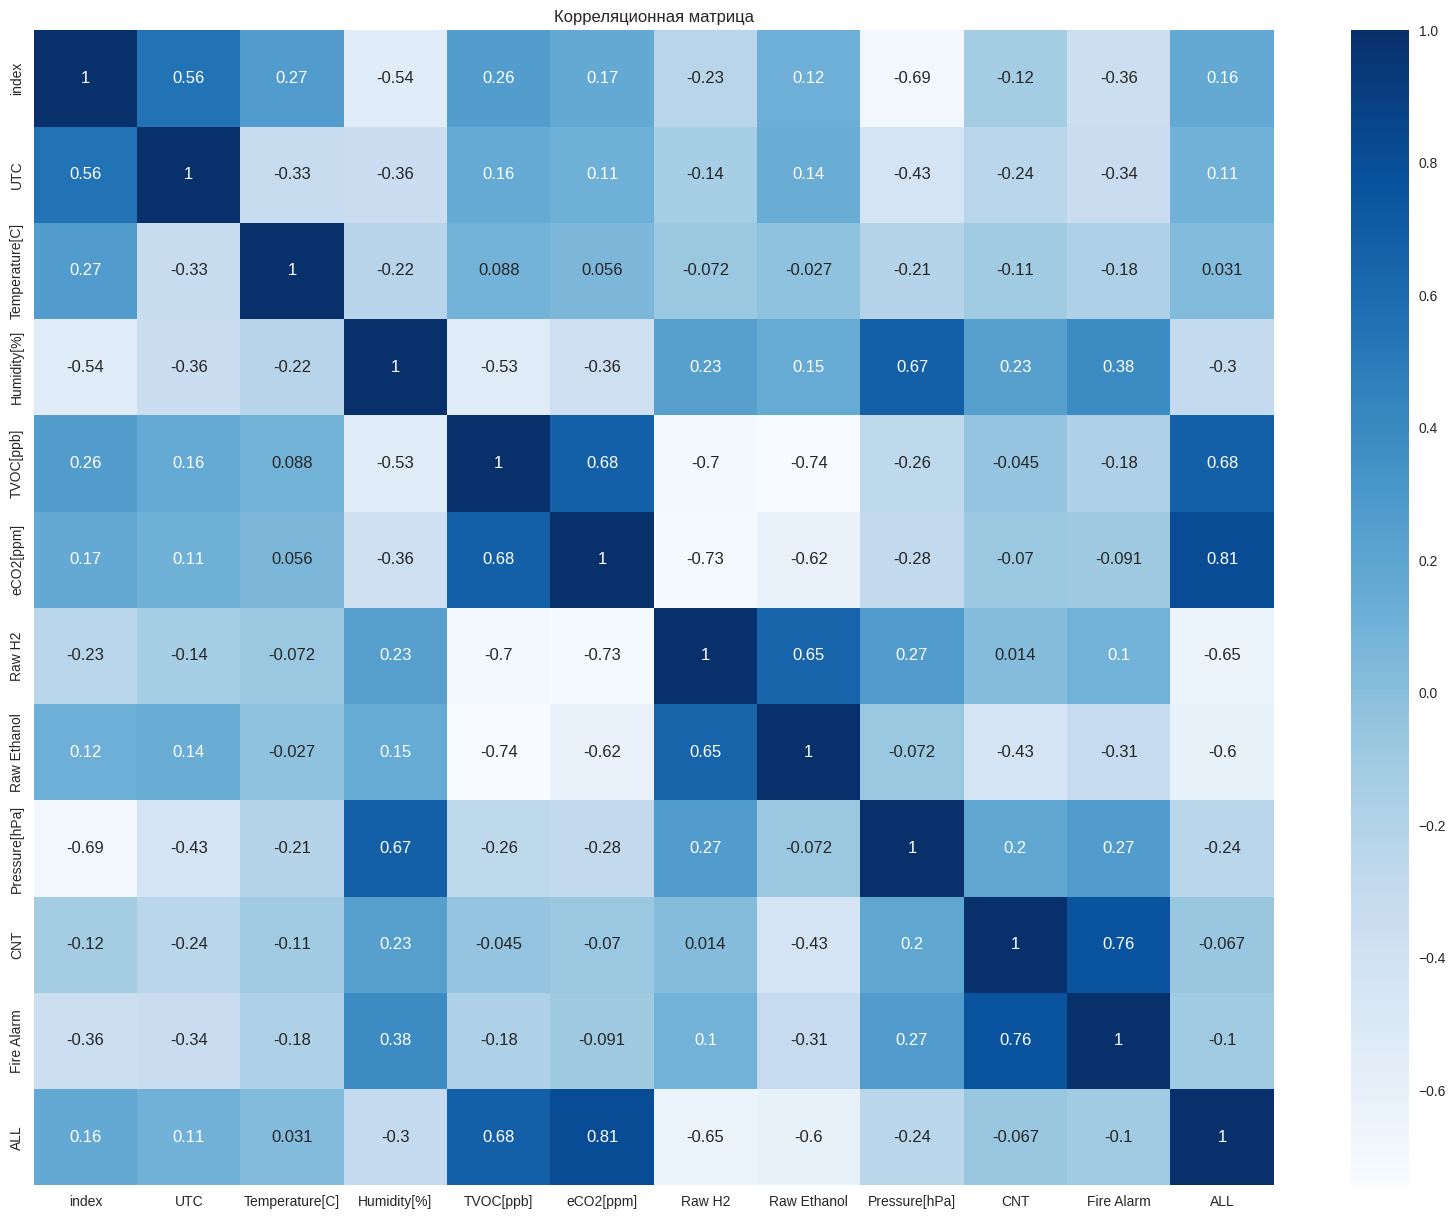

In [50]:
to_drop = ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'PM', 'NC']
df_agg = df_firealarm_mod.drop(columns=to_drop)

plt.figure(figsize=(20, 15))
sns.heatmap(df_agg.corr(), annot=True, cmap='Blues')
plt.title('Корреляционная матрица')
plt.show()

In [51]:
# ну и напоследок еще агрегируем ALL с eCO2
pca_all_co = PCA(n_components=1)
reduced_all_co = pca_nc.fit_transform(df_agg[['ALL', 'eCO2[ppm]']])
df_agg['ALL_CO'] = reduced_all_co[:, 0]

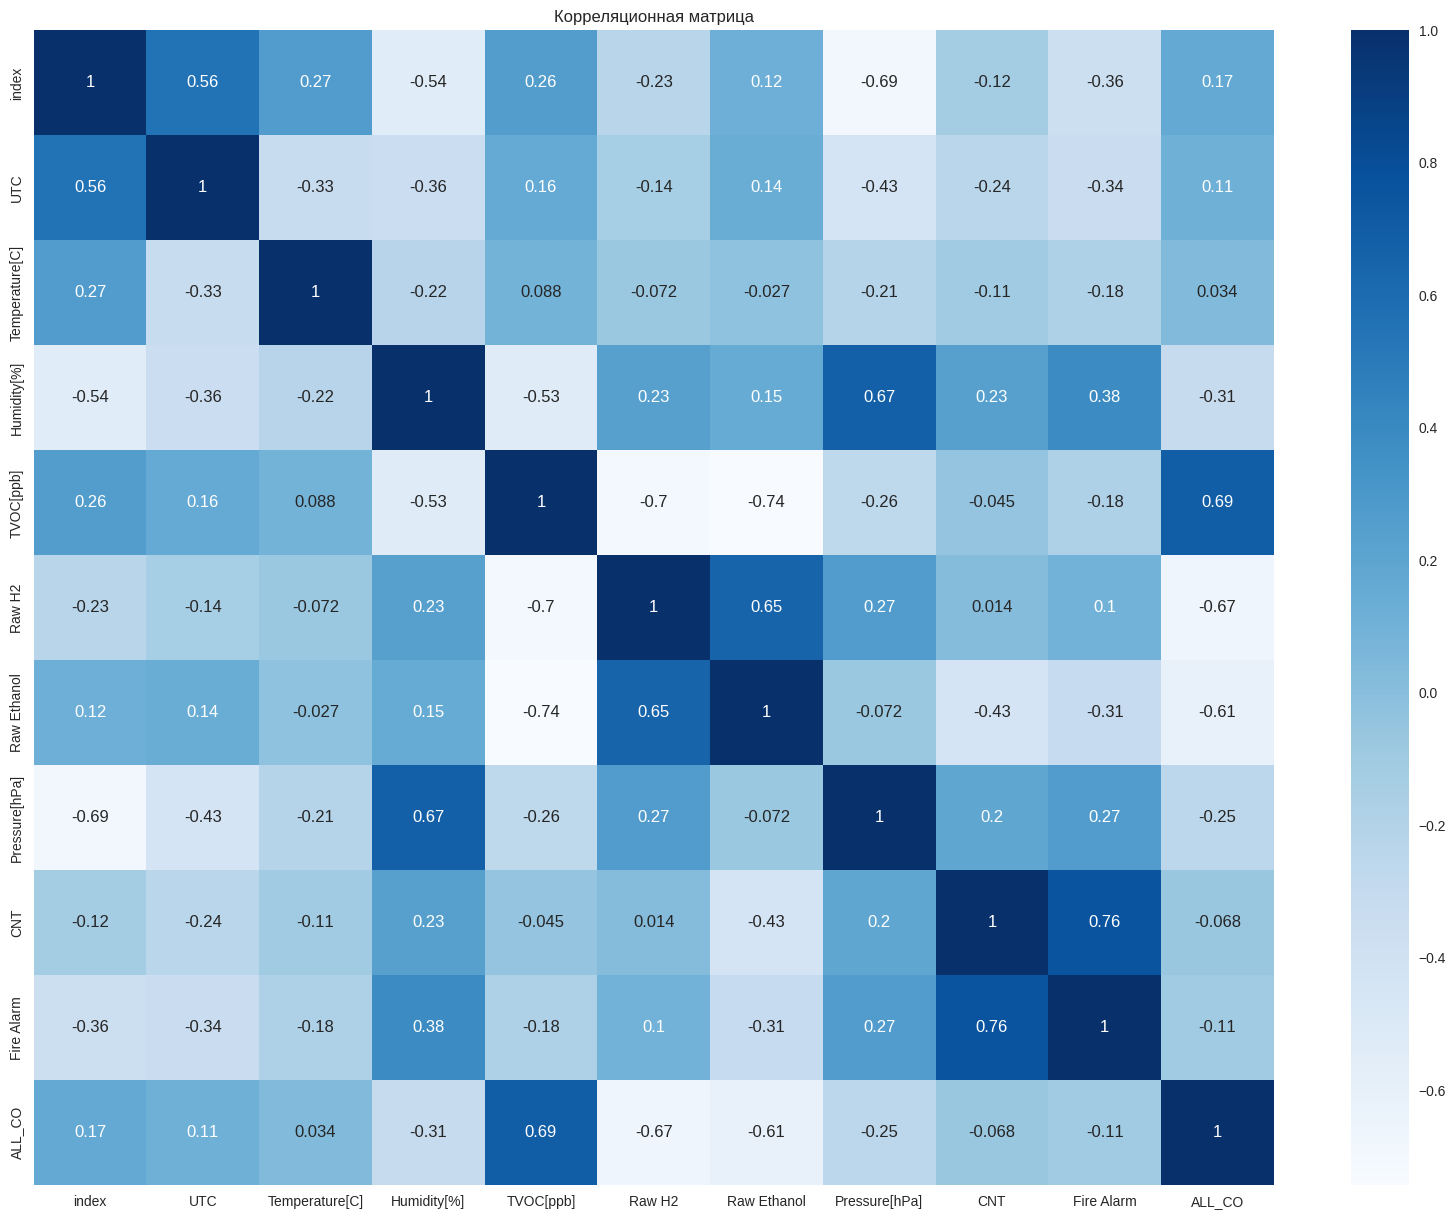

In [52]:
to_drop = ['ALL', 'eCO2[ppm]']
df_agg_2 = df_agg.drop(columns=to_drop)

plt.figure(figsize=(20, 15))
sns.heatmap(df_agg_2.corr(), annot=True, cmap='Blues')
plt.title('Корреляционная матрица')
plt.show()

Ну допустим подойдет. На всякий случай у нас есть оригинальный датасет, для сравнения будем обучать модели и на нем.

Метрики качества будут использованы такие же, как и в датасете с мобильными телефонами.

## Метрики качества

In [53]:
# немного переписаны
def get_classification_metrics(model, X_test, y_test):

    # general metrics
    y_preds = model.predict(X_test)
    print(classification_report(y_preds, y_test))

    # roc-auc
    y_proba = model.predict_proba(X_test)[:, 1]
    macro_auc = roc_auc_score(y_test,
                              y_proba,
                              multi_class='ovr',
                              average='macro')
    print('ROC-AUC is ', macro_auc)

## Логистическая регрессия: baseline

### Агрегированные данные: подготовка данных и обучение модели

In [54]:
col_to_drop = ['index', 'Fire Alarm', 'CNT']
X = df_agg_2.drop(col_to_drop, axis=1).copy()
y = df_agg_2['Fire Alarm'].copy()
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=random)

In [55]:
# нормализуем фичи в выборках

scaler = MinMaxScaler()

pandas_columns = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=pandas_columns)
X_test = pd.DataFrame(X_test, columns=pandas_columns)

In [56]:
# логистическая регрессия: базовая модель

logreg_baseline = LogisticRegression()
logreg_baseline.fit(X_train, y_train)

LogisticRegression()

In [57]:
get_classification_metrics(logreg_baseline, X_test, y_test)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1790
           1       0.88      0.91      0.89      1785

    accuracy                           0.89      3575
   macro avg       0.89      0.89      0.89      3575
weighted avg       0.89      0.89      0.89      3575

ROC-AUC is  0.9555674353900898


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


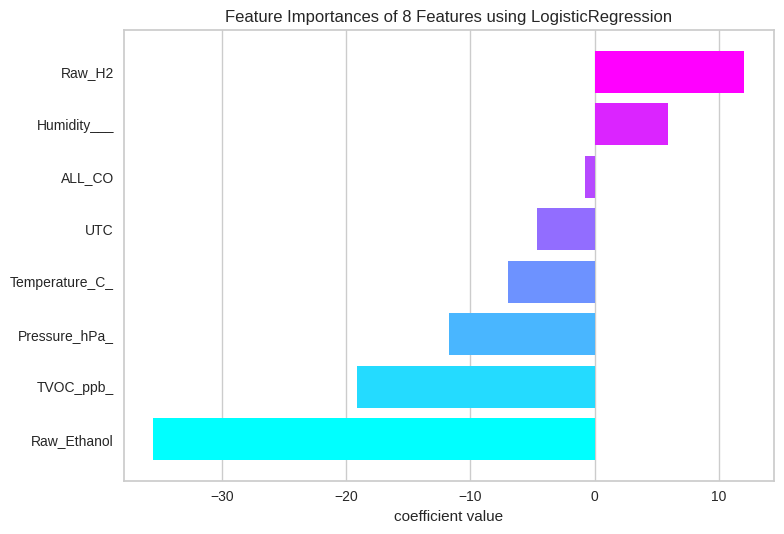

In [58]:
get_feature_importance(logreg_baseline, X_train, y_train)

### Оригинальные данные: подготовка данных и обучение модели

In [59]:
col_to_drop = ['index', 'Fire Alarm', 'CNT']
X_org = orig_saved.drop(col_to_drop, axis=1).copy()
X_org.columns = X_org.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
y_org = orig_saved['Fire Alarm'].copy()

X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X_org, y_org, test_size=0.1,
                                                    random_state=random)

In [60]:
# нормализуем фичи в выборках

pandas_columns = X_train_org.columns
X_train_org = scaler.fit_transform(X_train_org)
X_test_org = scaler.transform(X_test_org)

X_train_org = pd.DataFrame(X_train_org, columns=pandas_columns)
X_test_org = pd.DataFrame(X_test_org, columns=pandas_columns)

In [61]:
# логистическая регрессия: базовая модель

logreg_baseline_orgdt = LogisticRegression()
logreg_baseline_orgdt.fit(X_train_org, y_train_org)

LogisticRegression()

In [62]:
get_classification_metrics(logreg_baseline_orgdt, X_test_org, y_test_org)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1789
           1       0.88      0.91      0.89      1786

    accuracy                           0.89      3575
   macro avg       0.89      0.89      0.89      3575
weighted avg       0.89      0.89      0.89      3575

ROC-AUC is  0.9557625444475972


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


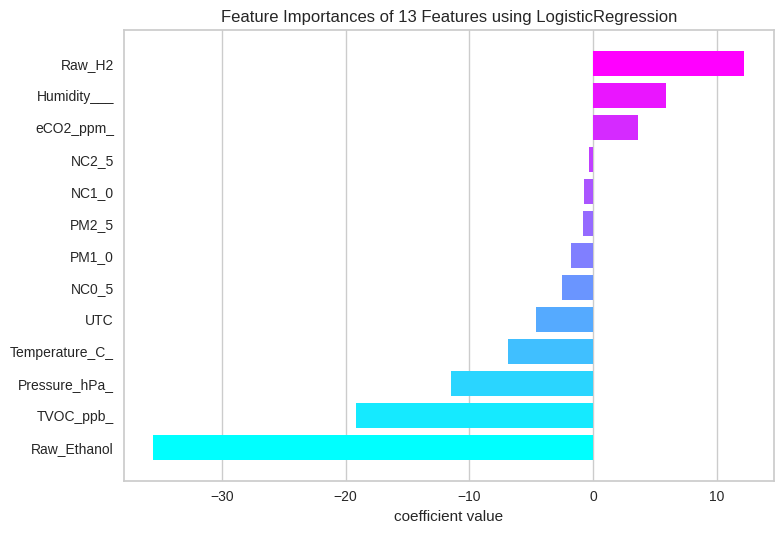

In [63]:
get_feature_importance(logreg_baseline_orgdt, X_train_org, y_train_org)

На бейзлайне метрики качества одинаковые. Для кросс-валидации возьмем модель с мЕньшим количеством предикторов. Распределение важности признаков примерно одинаковое

## Логистическая регрессия с подобранными гиперпараметрами

In [64]:
tuned_param = {'penalty': ['l1', 'l2', 'elasticnet', None],
               'C': [1, 10, 100, 1000],
               'solver': ['lbfgs', 'liblinear','newton-cg',
                          'newton-cholesky', 'sag', 'saga']}

clf = GridSearchCV(estimator=LogisticRegression(),
                   param_grid=tuned_param,
                   cv=5)

In [65]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [66]:
# получаем наиболее эффективные параметры
clf.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cholesky'}

In [67]:
logreg_crossval = LogisticRegression(**clf.best_params_)

logreg_crossval.fit(X_train, y_train)

LogisticRegression(C=100, solver='newton-cholesky')

In [68]:
# результаты
get_classification_metrics(logreg_crossval, X_test, y_test)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1825
           1       0.89      0.93      0.91      1750

    accuracy                           0.91      3575
   macro avg       0.91      0.91      0.91      3575
weighted avg       0.91      0.91      0.91      3575

ROC-AUC is  0.9632549827972062


Ура, результаты стали лучше!

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


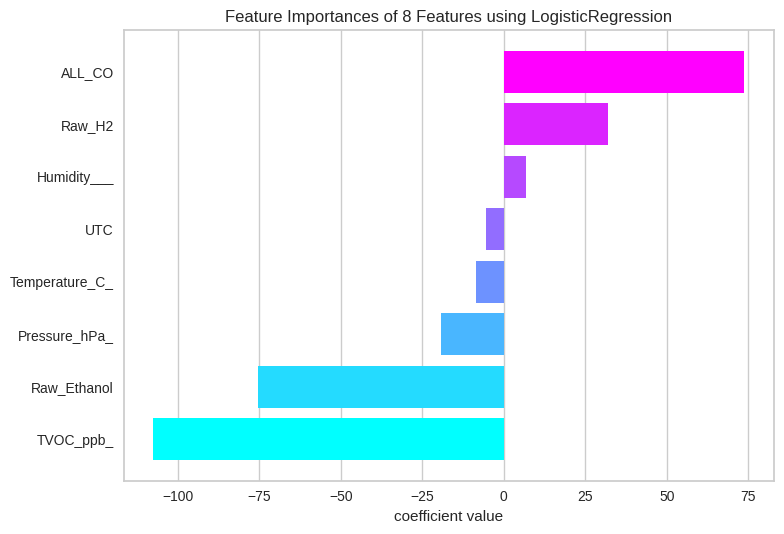

In [69]:
# важность признаков
get_feature_importance(logreg_crossval, X_train, y_train)

## LGBMClassifier: baseline

In [70]:
# инициализация модели
lgbm_baseline = LGBMClassifier()

# обучение
lgbm_baseline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16040, number of negative: 16131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 32171, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier()

In [71]:
# результаты
get_classification_metrics(lgbm_baseline, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1742
           1       1.00      1.00      1.00      1833

    accuracy                           1.00      3575
   macro avg       1.00      1.00      1.00      3575
weighted avg       1.00      1.00      1.00      3575

ROC-AUC is  1.0


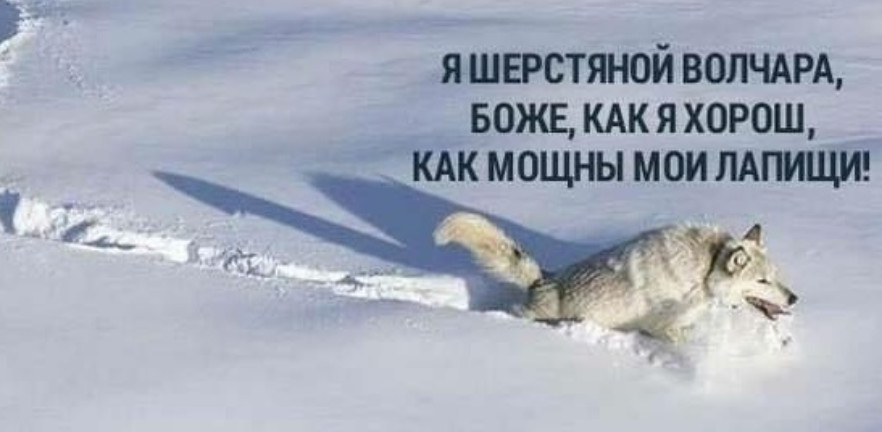

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


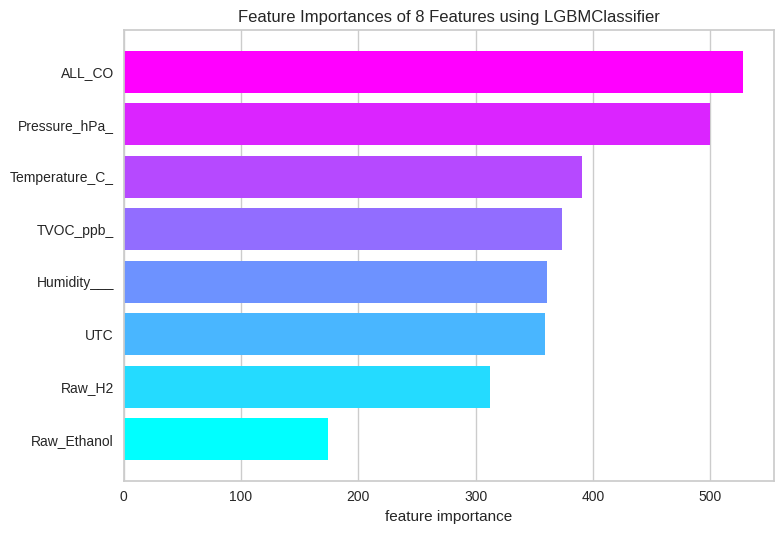

In [72]:
# важность признаков
get_feature_importance(lgbm_baseline, X_train, y_train)

## LGBMClassifier с подобранными гиперпараметрами
Лучше точно не будет, но давайте попробуем

In [73]:
# сразу самые важные параметры
params = {'max_depth': [-1, 5, 10, 15],
          'n_estimators': [100, 500, 1000],
          'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}


clf = GridSearchCV(estimator=LGBMClassifier(),
                   param_grid=params,
                   cv=5)

clf.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [-1, 5, 10, 15],
                         'n_estimators': [100, 500, 1000]})

In [74]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500}

In [75]:
lgbm_crossval = LGBMClassifier(**clf.best_params_)

lgbm_crossval.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16040, number of negative: 16131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 32171, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(n_estimators=500)

In [76]:
get_classification_metrics(lgbm_crossval, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1742
           1       1.00      1.00      1.00      1833

    accuracy                           1.00      3575
   macro avg       1.00      1.00      1.00      3575
weighted avg       1.00      1.00      1.00      3575

ROC-AUC is  1.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


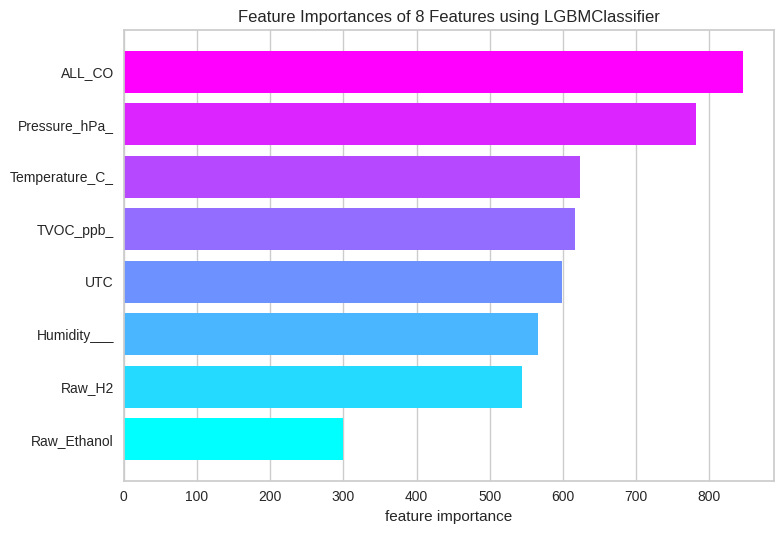

In [77]:
get_feature_importance(lgbm_crossval, X_train, y_train)

## Хорошие и плохие предсказания для бустинга

In [78]:
boosting_preds = lgbm_crossval.predict(X_test)

for i in range(len(boosting_preds)):
    if boosting_preds[i] == y_test.iloc[i]:
        print('Пример хорошего предсказания: ', y_test.iloc[i])
        print('Фичи: ', X_test.iloc[i])
        print('____')
    else:
        print(f"Пример плохого предсказания: реальное значение: {y_test.iloc[i]}; \
        предсказанное бустингом: {boosting_preds[i]}")
        print('Фичи: ', X_test.iloc[i])

Выходные данные были обрезаны до нескольких последних строк (5000).
Raw_H2            0.701435
Raw_Ethanol       0.893484
Pressure_hPa_     0.749029
ALL_CO            0.000349
Name: 3120, dtype: float64
____
Пример хорошего предсказания:  0
Фичи:  UTC               0.125091
Temperature_C_    0.496705
Humidity___       0.630158
TVOC_ppb_         0.002783
Raw_H2            0.792026
Raw_Ethanol       0.769408
Pressure_hPa_     0.978577
ALL_CO            0.000070
Name: 3121, dtype: float64
____
Пример хорошего предсказания:  0
Фичи:  UTC               0.057229
Temperature_C_    0.444435
Humidity___       0.643345
TVOC_ppb_         0.001667
Raw_H2            0.804466
Raw_Ethanol       0.780896
Pressure_hPa_     0.972694
ALL_CO            0.000096
Name: 3122, dtype: float64
____
Пример хорошего предсказания:  1
Фичи:  UTC               0.105853
Temperature_C_    0.000159
Humidity___       0.664133
TVOC_ppb_         0.022983
Raw_H2            0.733971
Raw_Ethanol       0.666831
Pressure_hPa_ 

## Сравнение LogLoss всех моделей

In [79]:
def get_logloss_graph(model, y_test, X_test):
    y_pred_proba = model.predict_proba(X_test)

    n_classes = y_pred_proba.shape[1]
    plt.figure(figsize=(10, 6))

    for class_idx in range(n_classes):
        prob_true, prob_pred = calibration_curve(
            (y_test == class_idx).astype(int),
            y_pred_proba[:, class_idx],
            n_bins=10)
        plt.plot(prob_pred, prob_true, label=f"Класс {class_idx}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.legend()
    plt.show()

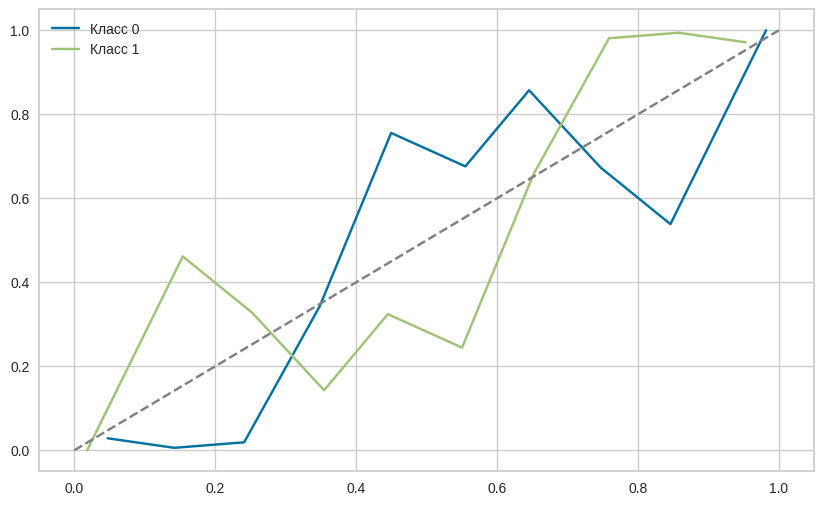

In [80]:
get_logloss_graph(logreg_baseline, y_test, X_test)

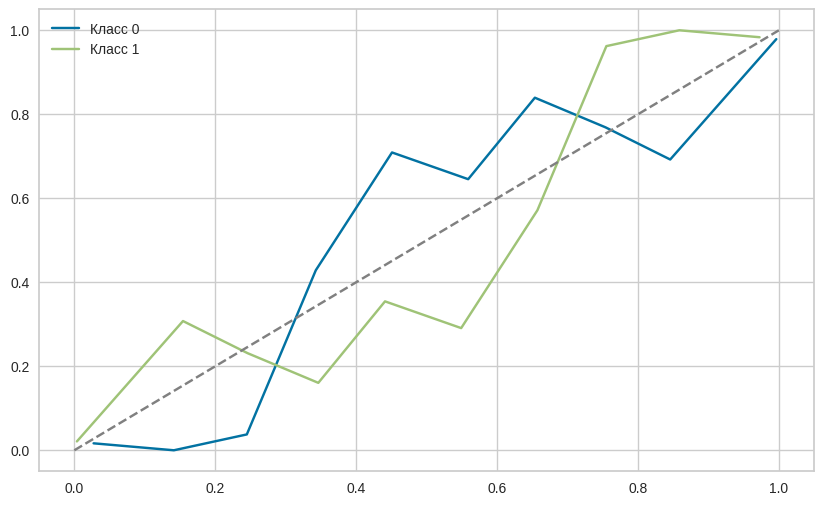

In [81]:
get_logloss_graph(logreg_crossval, y_test, X_test)

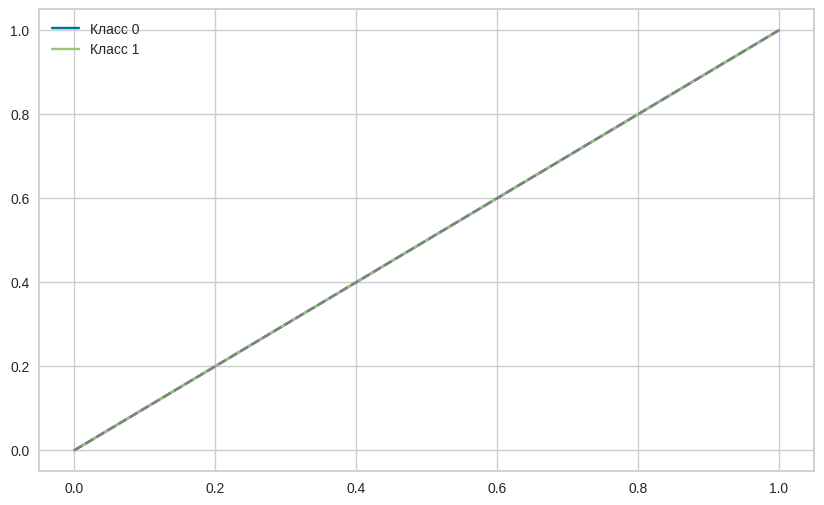

In [82]:
get_logloss_graph(lgbm_baseline, y_test, X_test)

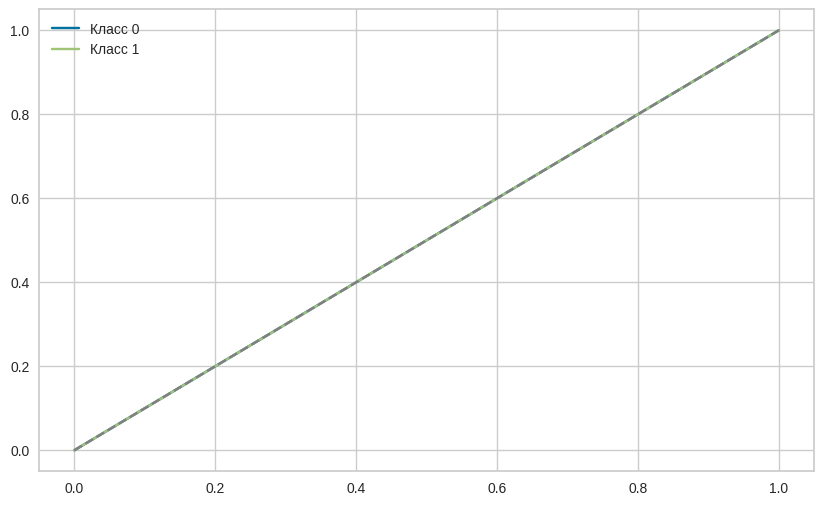

In [83]:
get_logloss_graph(lgbm_crossval, y_test, X_test)